In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

cristianjsanchez_dataset_path = kagglehub.dataset_download('cristianjsanchez/dataset')

print('Data source import complete.')


In [ ]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, matthews_corrcoef, accuracy_score, classification_report, precision_recall_curve
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
import lightgbm as lgb
from sklearn.svm import OneClassSVM
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
filename = "/DATASET.csv"
df = pd.read_csv(filename)

In [ ]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df.shape[0]

29704090

In [ ]:
df1=df.head(int(29704090*0.7))
df2=df.tail(int(29704090*0.3))

In [ ]:
print(df1.shape[0])
print(df2.shape[0])

20792863
8911227


In [ ]:
print(df1['Anomaly'].value_counts(normalize=True))
print(df2['Anomaly'].value_counts(normalize=True))

Anomaly
0    0.997266
4    0.001037
5    0.001007
3    0.000405
1    0.000199
2    0.000086
Name: proportion, dtype: float64
Anomaly
0    0.997259
5    0.001026
4    0.001019
3    0.000411
1    0.000197
2    0.000089
Name: proportion, dtype: float64


In [ ]:
total_transactions_df1 = df1['Transaction ID'].count()
df1['num_transactions_proportion'] = 1 / total_transactions_df1

df1['EntryDate'] = pd.to_datetime(df1['EntryDate'])
df1['Weekday'] = df1['EntryDate'].dt.weekday
df1['Hour'] = df1['EntryDate'].dt.hour

df1['Morning'] = df1['Hour'].apply(lambda x: 1 if 6 <= x < 12 else 0)  # Mañana (6:00 - 11:59)
df1['Evening'] = df1['Hour'].apply(lambda x: 1 if 12 <= x < 18 else 0)  # Tarde (12:00 - 17:59)
df1['Night'] = df1['Hour'].apply(lambda x: 1 if 18 <= x < 24 or 0 <= x < 6 else 0)  # Noche (18:00 - 23:59), (00:00 - 5:59)

condition_round_amount = ((df1['Normalized Amount'].apply(lambda x: str(x).count('000.0')) >= 1) & (df1['Normalized Amount'] == df1['Normalized Amount'].round()))
df1['Round_Amount_Condition'] = condition_round_amount.astype(int)

condition_small_amount = ((df1['Normalized Amount'] < 1177.44) & (df1['Normalized Amount'] > 420.65) & (df1['Product Class'] == 'Cash in / out (withdrawal), Security in / out'))
df1['Small_Amount_Condition'] = condition_small_amount

condition_sell = df1['InputOutput'] == 'Sell'
df1['Sell_Condition'] = condition_sell
condition_buy = df1['InputOutput'] == 'Buy'
df1['Buy_Condition'] = condition_buy

inoutdelta = (df1['InputOutput'] == 'Buy').astype(int) - (df1['InputOutput'] == 'Sell').astype(int)
df1['InputOutput_Delta'] = inoutdelta

condition_sell_cash = df1['Normalized Amount'].where(condition_sell & (df1['Product Class'] == 'Cash in / out (withdrawal), Security in / out'), 0)
df1['condition_sell_cash'] = condition_sell_cash

condition_sell_cash2 = df1['Normalized Amount'].where(condition_sell & (df1['Product Type'] == 'SimpleTransfer'), 0)
df1['condition_sell_cash2'] = condition_sell_cash2

aggregated_dftr = df1.groupby(['Originator', 'Weekday', 'Hour', 'Morning', 'Evening', 'Night', 'Anomaly']).agg(
    num_transactions=('num_transactions_proportion', 'sum'),
    total_amount_traded=('Normalized Amount', 'mean'),
    transactions_count_small_amount=('Small_Amount_Condition', 'mean'),
    transactions_count_round_amount=('Round_Amount_Condition', 'mean'),
    transactions_count_amount_sell=('Sell_Condition', 'mean'),
    transactions_count_amount_buy=('Buy_Condition', 'mean'),
    cash_out_withdrawal_security_out=('condition_sell_cash', 'mean'),
    simpletranfer=('condition_sell_cash2', 'mean'),
    inputoutput_delta=('InputOutput_Delta', 'mean')
).reset_index()

df1.drop(columns=['Weekday', 'Hour', 'Morning', 'Evening', 'Night', 'Round_Amount_Condition', 'Small_Amount_Condition', 'Sell_Condition', 'Buy_Condition', 'InputOutput_Delta', 'condition_sell_cash', 'condition_sell_cash2','num_transactions_proportion'], inplace=True)

/tmp/ipykernel_30/3483571805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['num_transactions_proportion'] = 1 / total_transactions_df1
/tmp/ipykernel_30/3483571805.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['EntryDate'] = pd.to_datetime(df1['EntryDate'])
/tmp/ipykernel_30/3483571805.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [ ]:
total_transactions_df2 = df2['Transaction ID'].count()
df2['num_transactions_proportion'] = 1 / total_transactions_df2

df2['EntryDate'] = pd.to_datetime(df2['EntryDate'])
df2['Weekday'] = df2['EntryDate'].dt.weekday
df2['Hour'] = df2['EntryDate'].dt.hour

df2['Morning'] = df2['Hour'].apply(lambda x: 1 if 6 <= x < 12 else 0)  # Mañana (6:00 - 11:59)
df2['Evening'] = df2['Hour'].apply(lambda x: 1 if 12 <= x < 18 else 0)  # Tarde (12:00 - 17:59)
df2['Night'] = df2['Hour'].apply(lambda x: 1 if 18 <= x < 24 or 0 <= x < 6 else 0)  # Noche (18:00 - 23:59), (00:00 - 5:59)

condition_round_amount = ((df2['Normalized Amount'].apply(lambda x: str(x).count('000.0')) >= 1) & (df2['Normalized Amount'] == df2['Normalized Amount'].round()))
df2['Round_Amount_Condition'] = condition_round_amount.astype(int)

condition_small_amount = ((df2['Normalized Amount'] < 1177.44) & (df2['Normalized Amount'] > 420.65) & (df2['Product Class'] == 'Cash in / out (withdrawal), Security in / out'))
df2['Small_Amount_Condition'] = condition_small_amount

condition_sell = df2['InputOutput'] == 'Sell'
df2['Sell_Condition'] = condition_sell
condition_buy = df2['InputOutput'] == 'Buy'
df2['Buy_Condition'] = condition_buy

inoutdelta = (df2['InputOutput'] == 'Buy').astype(int) - (df2['InputOutput'] == 'Sell').astype(int)
df2['InputOutput_Delta'] = inoutdelta

condition_sell_cash = df2['Normalized Amount'].where(condition_sell & (df2['Product Class'] == 'Cash in / out (withdrawal), Security in / out'), 0)
df2['condition_sell_cash'] = condition_sell_cash

condition_sell_cash2 = df2['Normalized Amount'].where(condition_sell & (df2['Product Type'] == 'SimpleTransfer'), 0)
df2['condition_sell_cash2'] = condition_sell_cash2

aggregated_dfte = df2.groupby(['Originator', 'Weekday', 'Hour', 'Morning', 'Evening', 'Night', 'Anomaly']).agg(
    num_transactions=('num_transactions_proportion', 'sum'),
    total_amount_traded=('Normalized Amount', 'mean'),
    transactions_count_small_amount=('Small_Amount_Condition', 'mean'),
    transactions_count_round_amount=('Round_Amount_Condition', 'mean'),
    transactions_count_amount_sell=('Sell_Condition', 'mean'),
    transactions_count_amount_buy=('Buy_Condition', 'mean'),
    cash_out_withdrawal_security_out=('condition_sell_cash', 'mean'),
    simpletranfer=('condition_sell_cash2', 'mean'),
    inputoutput_delta=('InputOutput_Delta', 'mean')
).reset_index()

df2.drop(columns=['Weekday', 'Hour', 'Morning', 'Evening', 'Night', 'Round_Amount_Condition', 'Small_Amount_Condition', 'Sell_Condition', 'Buy_Condition', 'InputOutput_Delta', 'condition_sell_cash', 'condition_sell_cash2','num_transactions_proportion'], inplace=True)

/tmp/ipykernel_30/3709150904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['num_transactions_proportion'] = 1 / total_transactions_df2
/tmp/ipykernel_30/3709150904.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['EntryDate'] = pd.to_datetime(df2['EntryDate'])
/tmp/ipykernel_30/3709150904.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [ ]:
import gc

del df
del df1
del df2

gc.collect()

87

In [ ]:
X_train = aggregated_dftr.drop(['Originator','Anomaly'], axis=1)
y_train = aggregated_dftr['Anomaly']
X_test = aggregated_dfte.drop(['Originator','Anomaly'], axis=1)
y_test = aggregated_dfte['Anomaly']

# **ALGORITMOS SUPERVISADOS**

**RANDOM FOREST**

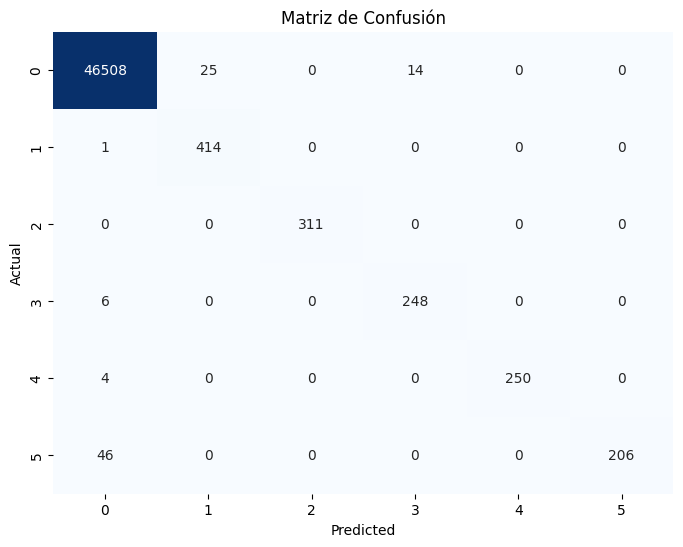

Reporte de clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     46547
           1       0.94      1.00      0.97       415
           2       1.00      1.00      1.00       311
           3       0.95      0.98      0.96       254
           4       1.00      0.98      0.99       254
           5       1.00      0.82      0.90       252

    accuracy                           1.00     48033
   macro avg       0.98      0.96      0.97     48033
weighted avg       1.00      1.00      1.00     48033

Accuracy:  0.998001374055337
Precision:  0.9813988636575237
F1-Score:  0.9702318566061274
True Positive Rate:  0.998001374055337
False Positive Rate:  0.00039972518893260884
False Negative Rate:  0.0019986259446630444
True Negative Rate:  0.9996002748110674
MCC:  0.9669133055800937
Training time (in seconds):  4.67279577255249


In [ ]:
start_time = time.time()
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=30,class_weight='balanced')
rf_classifier.fit(X_train, y_train)
end_time = time.time()
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred, average='macro')

f1 = f1_score(y_test, y_pred, average='macro')

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
report = classification_report(y_test, y_pred)
print("Reporte de clasificación:\n", report)

total_tp = total_fp = total_fn = total_tn = 0

for i in range(6):
    TP = conf_matrix[i, i]
    FP = conf_matrix[:, i].sum() - TP
    FN = conf_matrix[i, :].sum() - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    total_tp += TP
    total_fp += FP
    total_fn += FN
    total_tn += TN

TPR_global = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
FPR_global = total_fp / (total_fp + total_tn) if (total_fp + total_tn) > 0 else 0
FNR_global = total_fn / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
TNR_global = total_tn / (total_tn + total_fp) if (total_tn + total_fp) > 0 else 0

mcc_sklearn = matthews_corrcoef(y_test, y_pred)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1-Score: ', f1)
print('True Positive Rate: ', TPR_global)
print('False Positive Rate: ', FPR_global)
print('False Negative Rate: ', FNR_global)
print('True Negative Rate: ', TNR_global)
print('MCC: ', mcc_sklearn)
print('Training time (in seconds): ', end_time - start_time)

**CATBOOST**

In [ ]:
classes, class_counts = np.unique(y_train, return_counts=True)
print("Clases:", classes)
print("Distribución de clases:", class_counts)

Clases: [0 1 2 3 4 5]
Distribución de clases: [47920   544   449   279   254   252]


In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))

print("Pesos de las clases:", class_weights_dict)

Pesos de las clases: {0: 0.17285058430717862, 1: 15.226102941176471, 2: 18.447661469933184, 3: 29.688172043010752, 4: 32.610236220472444, 5: 32.86904761904762}


0:	learn: 1.7445057	total: 253ms	remaining: 4m 12s
100:	learn: 0.3810582	total: 14.4s	remaining: 2m 7s
200:	learn: 0.1325921	total: 29s	remaining: 1m 55s
300:	learn: 0.0510237	total: 45s	remaining: 1m 44s
400:	learn: 0.0210685	total: 1m	remaining: 1m 30s
500:	learn: 0.0096298	total: 1m 19s	remaining: 1m 19s
600:	learn: 0.0052030	total: 1m 34s	remaining: 1m 2s
700:	learn: 0.0033130	total: 1m 49s	remaining: 46.5s
800:	learn: 0.0024094	total: 2m 3s	remaining: 30.8s
900:	learn: 0.0019027	total: 2m 18s	remaining: 15.2s
999:	learn: 0.0015915	total: 2m 33s	remaining: 0us


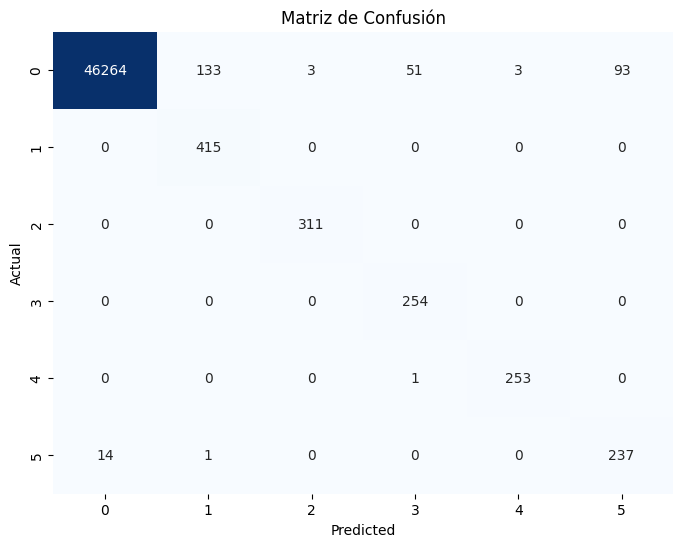

Reporte de clasificación:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     46547
           1       0.76      1.00      0.86       415
           2       0.99      1.00      1.00       311
           3       0.83      1.00      0.91       254
           4       0.99      1.00      0.99       254
           5       0.72      0.94      0.81       252

    accuracy                           0.99     48033
   macro avg       0.88      0.99      0.93     48033
weighted avg       1.00      0.99      0.99     48033

Accuracy:  0.9937751129431849
Precision:  0.8804319370427226
F1-Score:  0.9277881651865797
True Positive Rate:  0.9937751129431849
False Positive Rate:  0.0012449774113630213
False Negative Rate:  0.006224887056815107
True Negative Rate:  0.998755022588637
MCC:  0.9091307104898938
Training time (in seconds):  154.04668855667114


In [ ]:
catboost_classifier = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=10,
    random_seed=30,
    class_weights=class_weights.tolist(),
    verbose=100
)

start_time = time.time()
catboost_classifier.fit(X_train, y_train)
end_time = time.time()
y_pred = catboost_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred, average='macro')

f1 = f1_score(y_test, y_pred, average='macro')

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
report = classification_report(y_test, y_pred)
print("Reporte de clasificación:\n", report)

total_tp = total_fp = total_fn = total_tn = 0

for i in range(6):
    TP = conf_matrix[i, i]
    FP = conf_matrix[:, i].sum() - TP
    FN = conf_matrix[i, :].sum() - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    total_tp += TP
    total_fp += FP
    total_fn += FN
    total_tn += TN

TPR_global = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
FPR_global = total_fp / (total_fp + total_tn) if (total_fp + total_tn) > 0 else 0
FNR_global = total_fn / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
TNR_global = total_tn / (total_tn + total_fp) if (total_tn + total_fp) > 0 else 0

mcc_sklearn = matthews_corrcoef(y_test, y_pred)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1-Score: ', f1)
print('True Positive Rate: ', TPR_global)
print('False Positive Rate: ', FPR_global)
print('False Negative Rate: ', FNR_global)
print('True Negative Rate: ', TNR_global)
print('MCC: ', mcc_sklearn)
print('Training time (in seconds): ', end_time - start_time)

**DECISIONTREE**

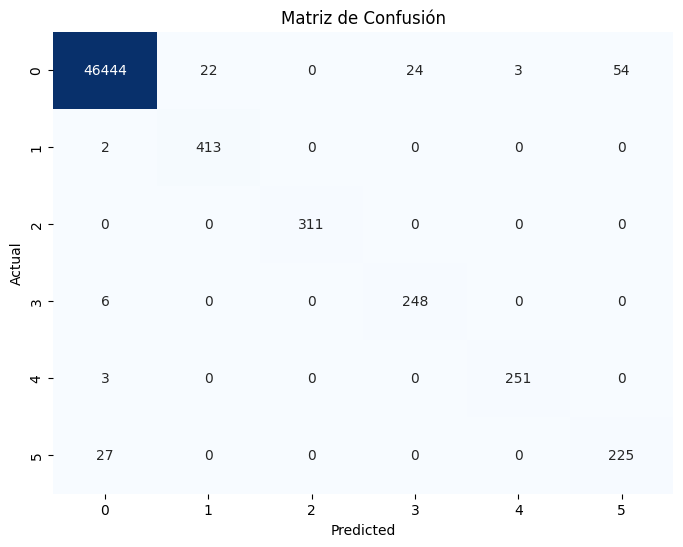

Reporte de clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     46547
           1       0.95      1.00      0.97       415
           2       1.00      1.00      1.00       311
           3       0.91      0.98      0.94       254
           4       0.99      0.99      0.99       254
           5       0.81      0.89      0.85       252

    accuracy                           1.00     48033
   macro avg       0.94      0.98      0.96     48033
weighted avg       1.00      1.00      1.00     48033

Accuracy:  0.9970645181437762
Precision:  0.9425021769598548
F1-Score:  0.9581435720730688
True Positive Rate:  0.9970645181437762
False Positive Rate:  0.0005870963712447693
False Negative Rate:  0.002935481856223846
True Negative Rate:  0.9994129036287552
MCC:  0.9528974586357056
Training time (in seconds):  0.2730250358581543


In [ ]:
start_time = time.time()
tree_classifier = DecisionTreeClassifier(random_state=30, class_weight='balanced')
tree_classifier.fit(X_train, y_train)
end_time = time.time()
y_pred = tree_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred, average='macro')

f1 = f1_score(y_test, y_pred, average='macro')

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
report = classification_report(y_test, y_pred)
print("Reporte de clasificación:\n", report)

total_tp = total_fp = total_fn = total_tn = 0

for i in range(6):
    TP = conf_matrix[i, i]
    FP = conf_matrix[:, i].sum() - TP
    FN = conf_matrix[i, :].sum() - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    total_tp += TP
    total_fp += FP
    total_fn += FN
    total_tn += TN

TPR_global = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
FPR_global = total_fp / (total_fp + total_tn) if (total_fp + total_tn) > 0 else 0
FNR_global = total_fn / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
TNR_global = total_tn / (total_tn + total_fp) if (total_tn + total_fp) > 0 else 0

mcc_sklearn = matthews_corrcoef(y_test, y_pred)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1-Score: ', f1)
print('True Positive Rate: ', TPR_global)
print('False Positive Rate: ', FPR_global)
print('False Negative Rate: ', FNR_global)
print('True Negative Rate: ', TNR_global)
print('MCC: ', mcc_sklearn)
print('Training time (in seconds): ', end_time - start_time)

**NAIVE BAYES**

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


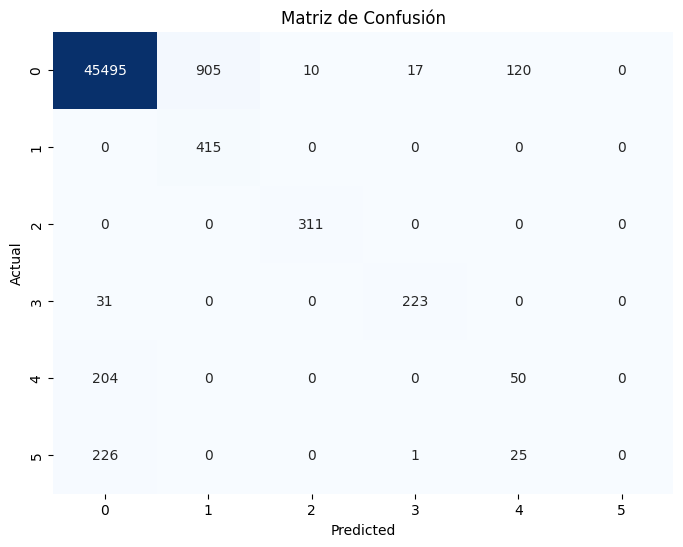

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     46547
           1       0.31      1.00      0.48       415
           2       0.97      1.00      0.98       311
           3       0.93      0.88      0.90       254
           4       0.26      0.20      0.22       254
           5       0.00      0.00      0.00       252

    accuracy                           0.97     48033
   macro avg       0.58      0.68      0.59     48033
weighted avg       0.97      0.97      0.97     48033

Accuracy:  0.9679595278246206
Precision:  0.5758219028048059
F1-Score:  0.5949890677138142
True Positive Rate:  0.9679595278246206
False Positive Rate:  0.0064080944350758855
False Negative Rate:  0.03204047217537943
True Negative Rate:  0.9935919055649242
MCC:  0.5674724495226114
Training time (in seconds):  0.02213263511657715


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
start_time=time.time()
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train, y_train)
end_time=time.time()
y_pred = naive_bayes_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred, average='macro')

f1 = f1_score(y_test, y_pred, average='macro')

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
report = classification_report(y_test, y_pred)
print("Reporte de clasificación:\n", report)

total_tp = total_fp = total_fn = total_tn = 0

for i in range(6):
    TP = conf_matrix[i, i]
    FP = conf_matrix[:, i].sum() - TP
    FN = conf_matrix[i, :].sum() - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    total_tp += TP
    total_fp += FP
    total_fn += FN
    total_tn += TN

TPR_global = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
FPR_global = total_fp / (total_fp + total_tn) if (total_fp + total_tn) > 0 else 0
FNR_global = total_fn / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
TNR_global = total_tn / (total_tn + total_fp) if (total_tn + total_fp) > 0 else 0

mcc_sklearn = matthews_corrcoef(y_test, y_pred)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1-Score: ', f1)
print('True Positive Rate: ', TPR_global)
print('False Positive Rate: ', FPR_global)
print('False Negative Rate: ', FNR_global)
print('True Negative Rate: ', TNR_global)
print('MCC: ', mcc_sklearn)
print('Training time (in seconds): ', end_time - start_time)

**LGBM**

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2130
[LightGBM] [Info] Number of data points in the train set: 49698, number of used features: 14
[LightGBM] [Info] Start training from score -0.036432
[LightGBM] [Info] Start training from score -4.514771
[LightGBM] [Info] Start training from score -4.706697
[LightGBM] [Info] Start training from score -5.182508
[LightGBM] [Info] Start training from score -5.276386
[LightGBM] [Info] Start training from score -5.284291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

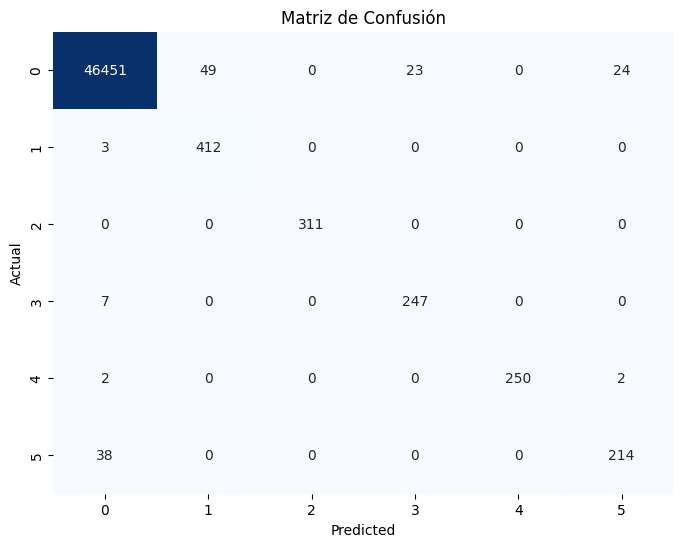

Reporte de clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     46547
           1       0.89      0.99      0.94       415
           2       1.00      1.00      1.00       311
           3       0.91      0.97      0.94       254
           4       1.00      0.98      0.99       254
           5       0.89      0.85      0.87       252

    accuracy                           1.00     48033
   macro avg       0.95      0.97      0.96     48033
weighted avg       1.00      1.00      1.00     48033

Accuracy:  0.9969187850019778
Precision:  0.9498525938894412
F1-Score:  0.9573000782726514
True Positive Rate:  0.9969187850019778
False Positive Rate:  0.0006162429996044386
False Negative Rate:  0.003081214998022193
True Negative Rate:  0.9993837570003956
MCC:  0.9501312029648254
Training time (in seconds):  2.763038158416748


In [ ]:
start_time = time.time()
lgb_classifier = lgb.LGBMClassifier(random_state=30)
lgb_classifier.fit(X_train, y_train)
end_time = time.time()

y_pred = lgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred, average='macro')

f1 = f1_score(y_test, y_pred, average='macro')

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
report = classification_report(y_test, y_pred)
print("Reporte de clasificación:\n", report)

total_tp = total_fp = total_fn = total_tn = 0

for i in range(6):
    TP = conf_matrix[i, i]
    FP = conf_matrix[:, i].sum() - TP
    FN = conf_matrix[i, :].sum() - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    total_tp += TP
    total_fp += FP
    total_fn += FN
    total_tn += TN

TPR_global = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
FPR_global = total_fp / (total_fp + total_tn) if (total_fp + total_tn) > 0 else 0
FNR_global = total_fn / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
TNR_global = total_tn / (total_tn + total_fp) if (total_tn + total_fp) > 0 else 0

mcc_sklearn = matthews_corrcoef(y_test, y_pred)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1-Score: ', f1)
print('True Positive Rate: ', TPR_global)
print('False Positive Rate: ', FPR_global)
print('False Negative Rate: ', FNR_global)
print('True Negative Rate: ', TNR_global)
print('MCC: ', mcc_sklearn)
print('Training time (in seconds): ', end_time - start_time)

# **ALGORITMOS NO SUPERVISADOS**

**ISOLATION FOREST**

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


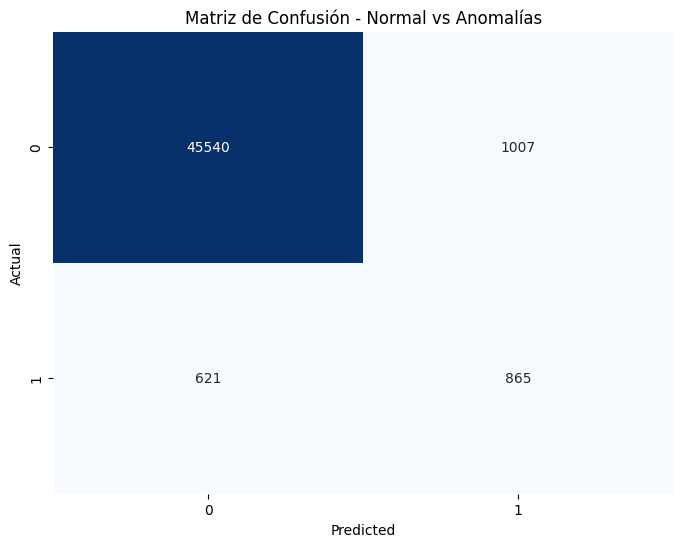

Reporte de clasificación (normal vs anomalías):
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     46547
           1       0.46      0.58      0.52      1486

    accuracy                           0.97     48033
   macro avg       0.72      0.78      0.75     48033
weighted avg       0.97      0.97      0.97     48033

Accuracy:  0.9661066350217559
Precision:  0.7243098673872217
F1-Score:  0.7488135495482457
True Positive Rate:  0.582099596231494
False Positive Rate:  0.021634047307023008
False Negative Rate:  0.41790040376850607
True Negative Rate:  0.978365952692977
MCC:  0.5014338499829353
Training time (in seconds):  1.402822494506836


In [ ]:
y_train_binary = [1 if label > 0 else 0 for label in y_train]
y_test_binary = [1 if label > 0 else 0 for label in y_test]

start_time = time.time()
iso_forest = IsolationForest(contamination=0.030937, random_state=30)
iso_forest.fit(X_train)
end_time = time.time()

y_pred = iso_forest.predict(X_test)
y_pred_binary = [1 if label == -1 else 0 for label in y_pred]

accuracy = accuracy_score(y_test_binary, y_pred_binary)

precision = precision_score(y_test_binary, y_pred_binary, average='macro')

f1 = f1_score(y_test_binary, y_pred_binary, average='macro')

conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Normal vs Anomalías')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
report = classification_report(y_test_binary, y_pred_binary)
print("Reporte de clasificación (normal vs anomalías):\n", report)

tp = conf_matrix[1, 1]
fn = conf_matrix[1, 0]
fp = conf_matrix[0, 1]
tn = conf_matrix[0, 0]

tpr_iso = tp / (tp + fn)
fpr_iso = fp / (fp + tn)
fnr_iso = fn / (fn + tp) if (fn + tp) > 0 else 0
tnr_iso = tn / (tn + fp) if (tn + fp) > 0 else 0

mcc_sklearn = matthews_corrcoef(y_test_binary, y_pred_binary)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1-Score: ', f1)
print('True Positive Rate: ', tpr_iso)
print('False Positive Rate: ', fpr_iso)
print('False Negative Rate: ', fnr_iso)
print('True Negative Rate: ', tnr_iso)
print('MCC: ', mcc_sklearn)
print('Training time (in seconds): ', end_time - start_time)

**AUTOENCODER**

Epoch 1/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.7779
Epoch 2/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6666
Epoch 3/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6324
Epoch 4/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6303
Epoch 5/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6335
Epoch 6/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.6587
Epoch 7/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6833
Epoch 8/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.6668
Epoch 9/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.6360
Epoch 10/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.6491
Epoch 11/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6196
Epoch 12/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6339
Epoch 13/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.6456
Epoch 14/50
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.6353
Epoch 15/50
1554/1554 ━━━━━━━

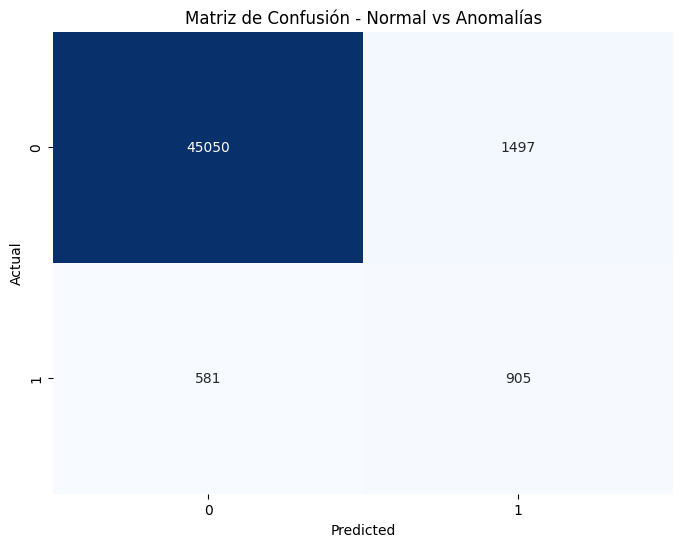

Reporte de clasificación (normal vs anomalías):
               precision    recall  f1-score   support

           0       0.99      0.97      0.98     46547
           1       0.38      0.61      0.47      1486

    accuracy                           0.96     48033
   macro avg       0.68      0.79      0.72     48033
weighted avg       0.97      0.96      0.96     48033

Accuracy:  0.9567380759061479
Precision:  0.6820183933563578
F1-Score:  0.7214958196822091
True Positive Rate:  0.6090174966352625
False Positive Rate:  0.032161041527918016
False Negative Rate:  0.39098250336473755
True Negative Rate:  0.967838958472082
MCC:  0.4582542638227882


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

input_dim = X_train_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(32, activation='relu')(input_layer)
encoder = Dense(16, activation='relu')(encoder)
decoder = Dense(32, activation='relu')(encoder)
output_layer = Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=32, shuffle=True)

X_test_reconstructed = autoencoder.predict(X_test_scaled)
reconstruction_errors = np.mean(np.power(X_test_scaled - X_test_reconstructed, 2), axis=1)

threshold = np.percentile(reconstruction_errors, 95)

y_pred_binary = [1 if error > threshold else 0 for error in reconstruction_errors]

accuracy = accuracy_score(y_test_binary, y_pred_binary)

precision = precision_score(y_test_binary, y_pred_binary, average='macro')

f1 = f1_score(y_test_binary, y_pred_binary, average='macro')

conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Normal vs Anomalías')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
report = classification_report(y_test_binary, y_pred_binary)
print("Reporte de clasificación (normal vs anomalías):\n", report)

tp = conf_matrix[1, 1]
fn = conf_matrix[1, 0]
fp = conf_matrix[0, 1]
tn = conf_matrix[0, 0]

tpr_auto = tp / (tp + fn)
fpr_auto = fp / (fp + tn)
fnr_auto = fn / (fn + tp) if (fn + tp) > 0 else 0
tnr_auto = tn / (tn + fp) if (tn + fp) > 0 else 0

mcc_sklearn = matthews_corrcoef(y_test_binary, y_pred_binary)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1-Score: ', f1)
print('True Positive Rate: ', tpr_auto)
print('False Positive Rate: ', fpr_auto)
print('False Negative Rate: ', fnr_auto)
print('True Negative Rate: ', tnr_auto)
print('MCC: ', mcc_sklearn)

**ONE CLASS SVM**

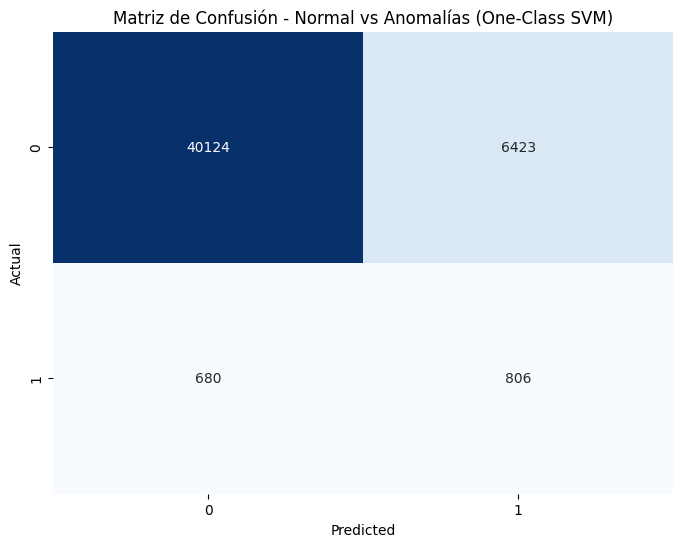

Reporte de clasificación (normal vs anomalías):
               precision    recall  f1-score   support

           0       0.98      0.86      0.92     46547
           1       0.11      0.54      0.18      1486

    accuracy                           0.85     48033
   macro avg       0.55      0.70      0.55     48033
weighted avg       0.96      0.85      0.90     48033

Accuracy:  0.8521224991151917
Precision:  0.5474151665237402
F1-Score:  0.5518264167410052
True Positive Rate:  0.5423956931359354
False Positive Rate:  0.1379895589404258
False Negative Rate:  0.4576043068640646
True Negative Rate:  0.8620104410595741
MCC:  0.19583147957415883
Training time (in seconds):  30.296321630477905


In [ ]:
start_time = time.time()
one_class_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1)
one_class_svm.fit(X_train)
end_time = time.time()

y_pred = one_class_svm.predict(X_test)
y_pred_binary = [1 if label == -1 else 0 for label in y_pred]

accuracy = accuracy_score(y_test_binary, y_pred_binary)

precision = precision_score(y_test_binary, y_pred_binary, average='macro')

f1 = f1_score(y_test_binary, y_pred_binary, average='macro')

conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Normal vs Anomalías (One-Class SVM)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
report = classification_report(y_test_binary, y_pred_binary)
print("Reporte de clasificación (normal vs anomalías):\n", report)

tp = conf_matrix[1, 1]
fn = conf_matrix[1, 0]
fp = conf_matrix[0, 1]
tn = conf_matrix[0, 0]

tpr_svm = tp / (tp + fn)
fpr_svm = fp / (fp + tn)
fnr_svm = fn / (fn + tp) if (fn + tp) > 0 else 0
tnr_svm = tn / (tn + fp) if (tn + fp) > 0 else 0

mcc_svm = matthews_corrcoef(y_test_binary, y_pred_binary)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1-Score: ', f1)
print('True Positive Rate: ', tpr_svm)
print('False Positive Rate: ', fpr_svm)
print('False Negative Rate: ', fnr_svm)
print('True Negative Rate: ', tnr_svm)
print('MCC: ', mcc_svm)
print('Training time (in seconds): ', end_time - start_time)

**K-NEAREST NEIGHBORS**

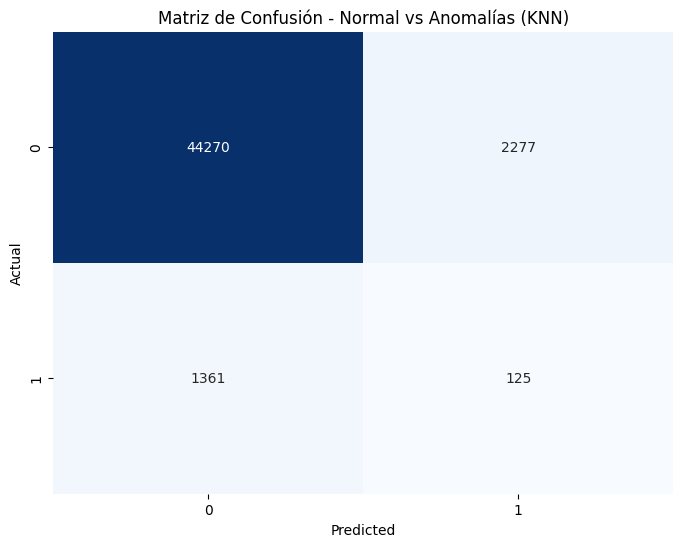

Reporte de clasificación (normal vs anomalías):
               precision    recall  f1-score   support

           0       0.97      0.95      0.96     46547
           1       0.05      0.08      0.06      1486

    accuracy                           0.92     48033
   macro avg       0.51      0.52      0.51     48033
weighted avg       0.94      0.92      0.93     48033

Accuracy:  0.9242604043053734
Precision:  0.5111068760298167
F1-Score:  0.5124166467776115
True Positive Rate:  0.08411843876177658
False Positive Rate:  0.04891829763464885
False Negative Rate:  0.9158815612382234
True Negative Rate:  0.9510817023653512
MCC:  0.027962961350009512
Training time (in seconds):  0.12596726417541504


In [ ]:
k = 7
start_time = time.time()
knn = NearestNeighbors(n_neighbors=k)
knn.fit(X_train)
end_time = time.time()

distances, indices = knn.kneighbors(X_test)
anomaly_scores = np.mean(distances, axis=1)
threshold = np.percentile(anomaly_scores, 95)
y_pred_binary = [1 if score > threshold else 0 for score in anomaly_scores]

accuracy = accuracy_score(y_test_binary, y_pred_binary)

precision = precision_score(y_test_binary, y_pred_binary, average='macro')

f1 = f1_score(y_test_binary, y_pred_binary, average='macro')

conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Normal vs Anomalías (KNN)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
report = classification_report(y_test_binary, y_pred_binary)
print("Reporte de clasificación (normal vs anomalías):\n", report)

tp = conf_matrix[1, 1]
fn = conf_matrix[1, 0]
fp = conf_matrix[0, 1]
tn = conf_matrix[0, 0]

tpr_knn = tp / (tp + fn)
fpr_knn = fp / (fp + tn)
fnr_knn = fn / (fn + tp) if (fn + tp) > 0 else 0
tnr_knn = tn / (tn + fp) if (tn + fp) > 0 else 0

mcc_knn = matthews_corrcoef(y_test_binary, y_pred_binary)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1-Score: ', f1)
print('True Positive Rate: ', tpr_knn)
print('False Positive Rate: ', fpr_knn)
print('False Negative Rate: ', fnr_knn)
print('True Negative Rate: ', tnr_knn)
print('MCC: ', mcc_knn)
print('Training time (in seconds): ', end_time - start_time)

**LOCAL OUTLIER FACTOR**

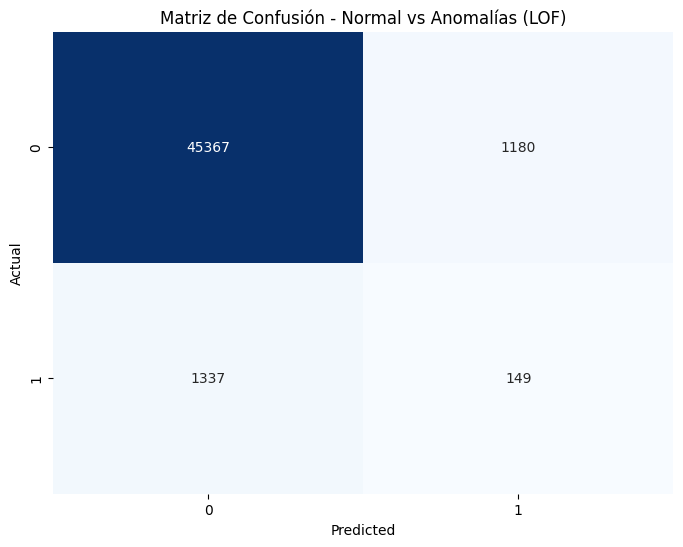

Reporte de clasificación (normal vs anomalías - LOF):
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     46547
           1       0.11      0.10      0.11      1486

    accuracy                           0.95     48033
   macro avg       0.54      0.54      0.54     48033
weighted avg       0.94      0.95      0.95     48033

Accuracy:  0.9475985260133658
Precision:  0.5417436366933541
F1-Score:  0.5394348944167248
True Positive Rate:  0.10026917900403769
False Positive Rate:  0.025350720776849207
False Negative Rate:  0.8997308209959624
True Negative Rate:  0.9746492792231508
MCC:  0.0790869003294728
Training time (in seconds):  1.5148677825927734


In [ ]:
start_time = time.time()
lof = LocalOutlierFactor(n_neighbors=20)
y_pred = lof.fit_predict(X_test)
end_time = time.time()

y_pred_binary = [1 if label == -1 else 0 for label in y_pred]

accuracy = accuracy_score(y_test_binary, y_pred_binary)

precision = precision_score(y_test_binary, y_pred_binary, average='macro', zero_division=0)

f1 = f1_score(y_test_binary, y_pred_binary, average='macro', zero_division=0)

conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Normal vs Anomalías (LOF)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
report = classification_report(y_test_binary, y_pred_binary)
print("Reporte de clasificación (normal vs anomalías - LOF):\n", report)

tp = conf_matrix[1, 1]
fn = conf_matrix[1, 0]
fp = conf_matrix[0, 1]
tn = conf_matrix[0, 0]

tpr_lof = tp / (tp + fn) if (tp + fn) > 0 else 0
fpr_lof = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr_lof = fn / (fn + tp) if (fn + tp) > 0 else 0
tnr_lof = tn / (tn + fp) if (tn + fp) > 0 else 0

mcc_lof = matthews_corrcoef(y_test_binary, y_pred_binary)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1-Score: ', f1)
print('True Positive Rate: ', tpr_lof)
print('False Positive Rate: ', fpr_lof)
print('False Negative Rate: ', fnr_lof)
print('True Negative Rate: ', tnr_lof)
print('MCC: ', mcc_lof)
print('Training time (in seconds): ', end_time - start_time)

In [ ]:
y_scores_iso = iso_forest.decision_function(X_test)
auc_iso = roc_auc_score(y_test_binary, -y_scores_iso)
fpr_iso, tpr_iso, _ = roc_curve(y_test_binary, -y_scores_iso)

reconstruction_errors = np.mean(np.power(X_test_scaled - X_test_reconstructed, 2), axis=1)
auc_auto = roc_auc_score(y_test_binary, reconstruction_errors)
fpr_auto, tpr_auto, _ = roc_curve(y_test_binary, reconstruction_errors)

y_scores_svm = one_class_svm.decision_function(X_test)
auc_svm = roc_auc_score(y_test_binary, -y_scores_svm)
fpr_svm, tpr_svm, _ = roc_curve(y_test_binary, -y_scores_svm)

auc_knn = roc_auc_score(y_test_binary, anomaly_scores)
fpr_knn, tpr_knn, _ = roc_curve(y_test_binary, anomaly_scores)

y_scores_lof = -lof.negative_outlier_factor_
auc_lof = roc_auc_score(y_test_binary, y_scores_lof)
fpr_lof, tpr_lof, _ = roc_curve(y_test_binary, y_scores_lof)

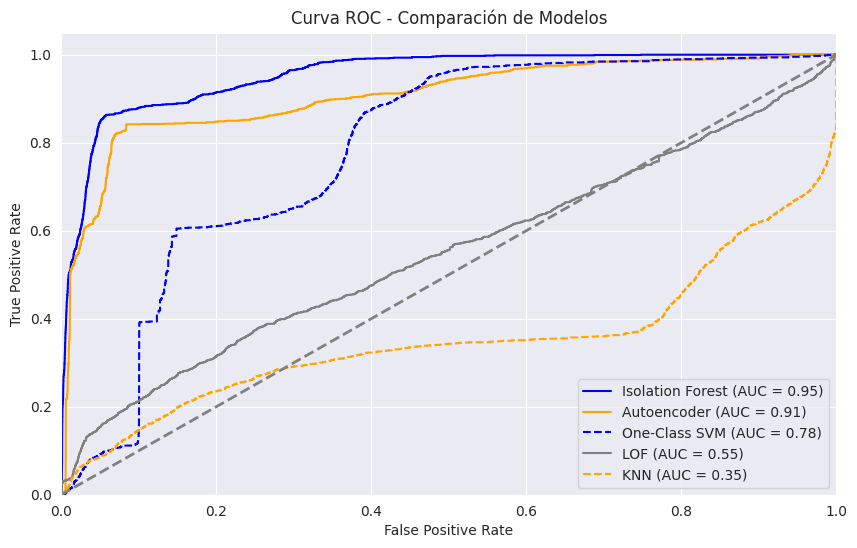

In [ ]:
sns.set_style("darkgrid")

plt.figure(figsize=(10, 6))
plt.plot(fpr_iso, tpr_iso, color='blue', lw=1.5, label='Isolation Forest (AUC = %0.2f)' % auc_iso)
plt.plot(fpr_auto, tpr_auto, color='orange', lw=1.5, label='Autoencoder (AUC = %0.2f)' % auc_auto)
plt.plot(fpr_svm, tpr_svm, color='blue', linestyle='--', lw=1.5, label='One-Class SVM (AUC = %0.2f)' % auc_svm)
plt.plot(fpr_lof, tpr_lof, color='gray', lw=1.5, label='LOF (AUC = %0.2f)' % auc_lof)
plt.plot(fpr_knn, tpr_knn, color='orange', linestyle='--', lw=1.5, label='KNN (AUC = %0.2f)' % auc_knn)

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.title('Curva ROC - Comparación de Modelos')
plt.legend(loc="lower right")
plt.show()

In [ ]:
precision_iso, recall_iso, _ = precision_recall_curve(y_test_binary, -y_scores_iso)
precision_auto, recall_auto, _ = precision_recall_curve(y_test_binary, reconstruction_errors)
precision_svm, recall_svm, _ = precision_recall_curve(y_test_binary, -y_scores_svm)
precision_knn, recall_knn, _ = precision_recall_curve(y_test_binary, anomaly_scores)
precision_lof, recall_lof, _ = precision_recall_curve(y_test_binary, y_scores_lof)

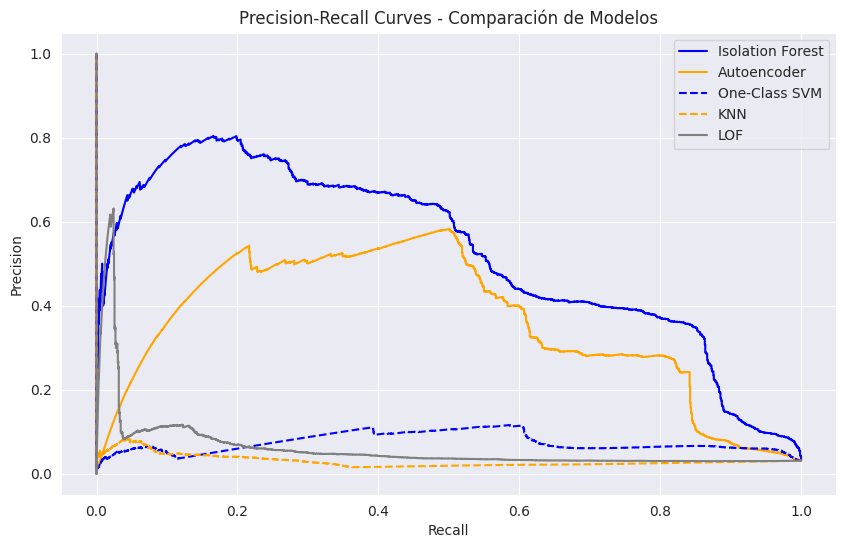

In [ ]:
sns.set_style("darkgrid")

plt.figure(figsize=(10, 6))
plt.plot(recall_iso, precision_iso, color='blue', lw=1.5, label='Isolation Forest')
plt.plot(recall_auto, precision_auto, color='orange', lw=1.5, label='Autoencoder')
plt.plot(recall_svm, precision_svm, color='blue', linestyle='--', lw=1.5, label='One-Class SVM')
plt.plot(recall_knn, precision_knn, color='orange', linestyle='--', lw=1.5, label='KNN')
plt.plot(recall_lof, precision_lof, color='gray', lw=1.5, label='LOF')

plt.xlabel('Recall', fontsize=10)
plt.ylabel('Precision', fontsize=10)
plt.title('Precision-Recall Curves - Comparación de Modelos')
plt.legend(loc="upper right")
plt.show()

**Guardar Mejores Algoritmos**

In [ ]:
import joblib

joblib.dump(rf_classifier, 'random_forest_model.pkl')
joblib.dump(iso_forest, 'iso_forest_model.pkl')

['iso_forest_model.pkl']